In [12]:
#Load the dataset

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


X_train= pd.read_csv('./X_train_all_feature.csv',index_col=0)
y_train= pd.read_csv('./y_train_all_feature.csv')
X_test= pd.read_csv('./X_test_all_feature.csv', index_col=0)
y_test= pd.read_csv('./y_test_all_feature.csv')
X_test.fillna(0,inplace=True)

In [13]:
# drop the useless features


X_train.drop(columns=['TotalTeDiagCode','TotalTeProcCode'],inplace=True)
X_test.drop(columns=['TotalTeDiagCode','TotalTeProcCode'],inplace=True)

In [14]:
#Randomforestclassifier

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
steps = [('Rescale', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators =5, criterion = 'entropy', 
                                     random_state = 0,class_weight='balanced',
                                     min_samples_split=50,oob_score=True,
                                     max_features='sqrt',max_depth=50))]
model = Pipeline(steps)
model = model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


In [15]:
# Evaluation metric(Written by Xin, check the detail with notebook: MetricPipeline.ipynb)

from MetricPipeline import Metric_pipeline    
mp=Metric_pipeline(X_train,y_train,X_test,y_test,model)
mp.metrics()

,0,1
0,roc_auc_score(train),0.980
1,roc_auc_score(test),0.938
2,PR-AUC(train),0.854
3,PR-AUC(test),0.680
4,average_precision(train),0.854
5,average_precision(test),0.681
6,precision_score(train),0.952
7,precision_score(test),0.933


# Feature selection

In [16]:
#caculate the feature imprortances
feat_labels = X_train.columns
importances = model.steps[1][1].feature_importances_
indices = np.argsort(importances)[::-1]
res=[]
for f in range(X_train.shape[1]):
    #print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
    res.append([feat_labels[indices[f]], importances[indices[f]]])
df_importances=pd.DataFrame(res)
#threshold = 0.055
#list(df_importances[df_importances[1]>threshold ][0])# feature importance > threshold 

In [20]:
#print out the importances of all features
df_importances

,0,1
0,TotalInscClaimAmtReimbursed,0.174655
1,totalDiagCode_41401,0.124984
2,TotalProcCodeNum,0.106753
3,TotalIPAnnualDeductibleAmtdf,0.089093
4,MeanProcCodeNumPerClaim,0.081584
...,...,...
97,totalProcCode_4019,0.000000
98,totalDiagCode_2589,0.000000
99,totalDiagCode_496,0.000000
100,totalDiagCode_53081,0.000000


In [17]:

#change the figure size of a seaborn plot
sns.set(rc={'figure.figsize':(11.7,8.27)})

Test PR-AUC is 0.706
Test PR-AUC is 0.710
Test PR-AUC is 0.679
Test PR-AUC is 0.736
Test PR-AUC is 0.717
Test PR-AUC is 0.725
Test PR-AUC is 0.694
Test PR-AUC is 0.673
Test PR-AUC is 0.687
Test PR-AUC is 0.702


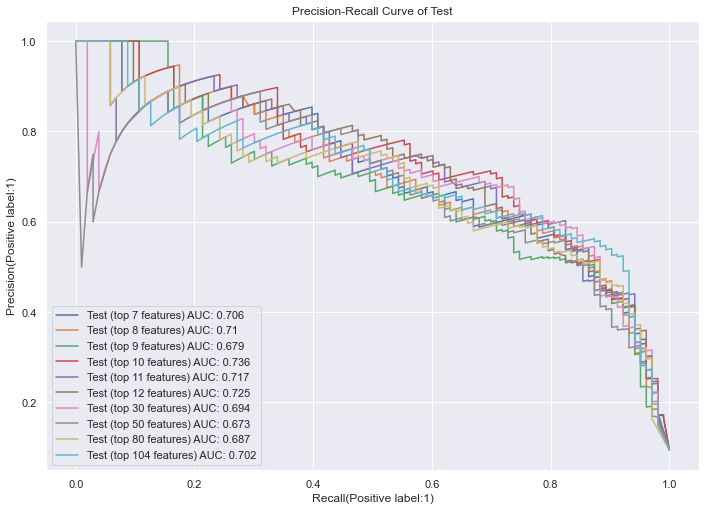

In [18]:

# check the PR_auc curve of Test set along with different feature selection. 

from sklearn.preprocessing import MinMaxScaler
for i in [7,8,9,10,11,12,30,50,80,104]:
    top_importances=df_importances[0][:i]
    X_train_temp=pd.DataFrame(X_train,columns=top_importances)
    X_test_temp=pd.DataFrame(X_test,columns=top_importances)
    
    steps = [('Rescale', MinMaxScaler()),
             ('rfc', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', 
                                     random_state = 0,class_weight='balanced',
                                     min_samples_split=50,oob_score=True,
                                     max_features='sqrt',max_depth=50))]
    model = Pipeline(steps)
    model = model.fit(X_train_temp,y_train)
    y_train_pred = model.predict(X_train_temp)
    y_test_pred = model.predict(X_test_temp)

    from Metric_Curves import multi_curves 
    mp=multi_curves(X_train_temp,y_train,X_test_temp,y_test,model)
    mp.plot_PR_test(i)
    

In [21]:
# top 12 features 
df_importances[0][:12]

0       TotalInscClaimAmtReimbursed
1               totalDiagCode_41401
2                  TotalProcCodeNum
3      TotalIPAnnualDeductibleAmtdf
4           MeanProcCodeNumPerClaim
5                   MaxHospitalDays
6                         InClmsPct
7         OPAnnualDeductibleAmt_sum
8     TotalIPAnnualReimbursementAmt
9                        MajorState
10            RenalDiseaseIndicator
11                 MeanHospitalDays
Name: 0, dtype: object

In [22]:
# Total features importance of top 12 features
df_importances[1][:12].sum()

0.7555492014692189

In [24]:
# change the train test data to 12 features
features=df_importances[0][:12].tolist()

In [25]:
n=12
X_train= pd.read_csv('./X_train_all_feature.csv',index_col=0)
X_test= pd.read_csv('./X_test_all_feature.csv', index_col=0)
X_train=pd.DataFrame(X_train,columns=df_importances[0][:n])
X_test=pd.DataFrame(X_test,columns=df_importances[0][:n])
X_test.fillna(0,inplace=True)

Text(0.5, 0, 'Feature Importances')

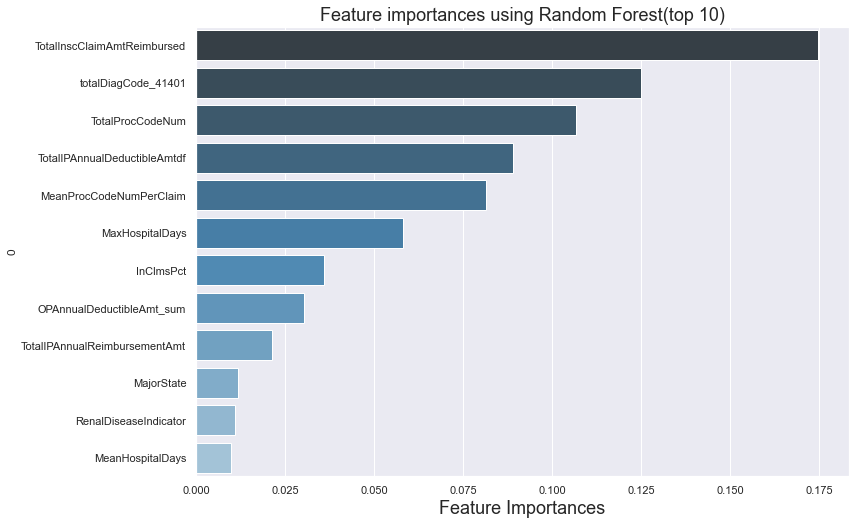

In [26]:
#Plot a barplot of top 12 features importance
palette = sns.color_palette("Blues_d",n_colors=12)
palette.reverse()
sns.barplot(x=1, y=0, data=df_importances.head(12),palette=palette)

plt.title("Feature importances using Random Forest(top 10)",fontsize=18)
plt.xlabel("Feature Importances",fontsize=18)

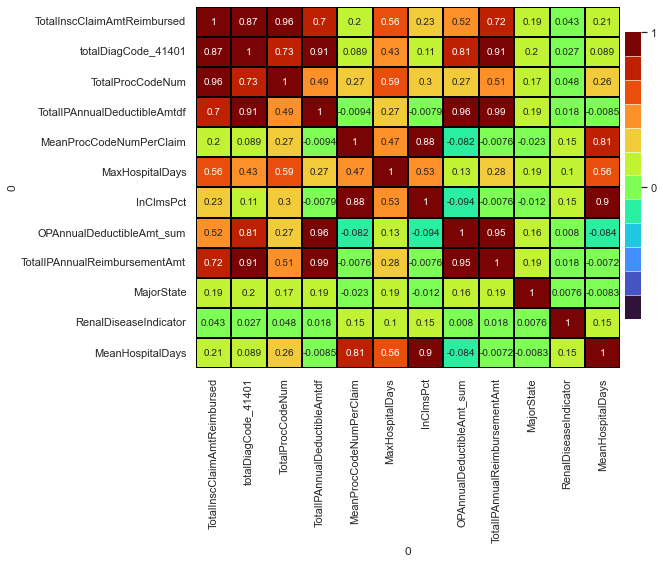

In [72]:
# Correlation of top 12 features
from matplotlib.colors import ListedColormap
binspivot = (12.02 * np.random.rand(20, 20) ** .5).astype(int)
maxfold = binspivot.max()
fig, ax = plt.subplots(figsize=(10, 8))

cbar_kws = dict(pad=0.01, shrink=0.86, drawedges=True, ticks=range(int(maxfold) + 1))  # Colorbar size and location

cmap1 = plt.get_cmap('turbo', maxfold + 1)
colors = ['white'] + list(plt.get_cmap('turbo', maxfold).colors)
cmap = ListedColormap(colors=colors)
sns.heatmap(X_train.corr(), cmap=cmap, linewidths=0.01, linecolor='black', vmin=-1, vmax=1,
            annot=True, annot_kws={"size": 10}, cbar_kws=cbar_kws, ax=ax)
plt.tight_layout()
plt.show()
#plt.savefig('../pics/Provider_Gender_Age_rf') #save the figure

# Model using new X set(12 features)

In [27]:

steps = [('Rescale', StandardScaler()),
         ('rfc', RandomForestClassifier(n_estimators =5, criterion = 'entropy', 
                                     random_state = 0,class_weight='balanced',
                                     min_samples_split=50,oob_score=True,
                                     max_features='sqrt',max_depth=50))]
model_reduct = Pipeline(steps)
model_reduct = model_reduct.fit(X_train,y_train)
y_train_pred_reduct = model_reduct.predict(X_train)
y_test_pred_reduct = model_reduct.predict(X_test)


In [28]:
#check the evaluation scores
from MetricPipeline import Metric_pipeline    
mp=Metric_pipeline(X_train,y_train,X_test,y_test,model_reduct)
mp.metrics()

,0,1
0,roc_auc_score(train),0.977
1,roc_auc_score(test),0.941
2,PR-AUC(train),0.826
3,PR-AUC(test),0.722
4,average_precision(train),0.826
5,average_precision(test),0.721
6,precision_score(train),0.950
7,precision_score(test),0.936


Test PR-AUC is 0.722


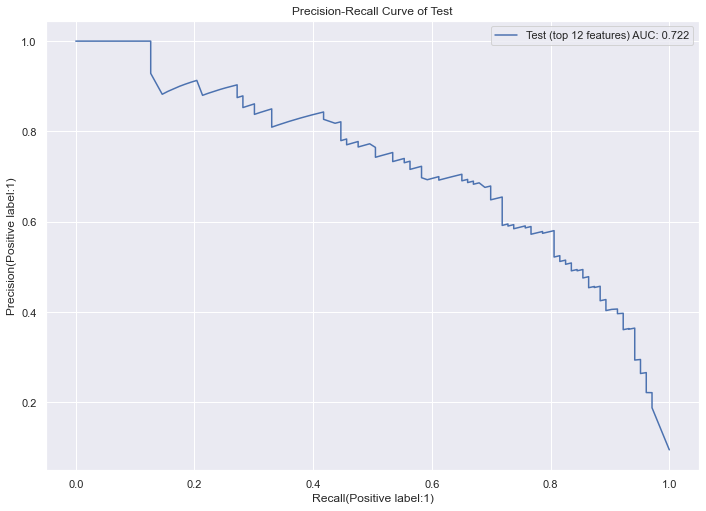

In [29]:
# PR curves plots (written by Xin ,check the file:Metric_Curves.ipynb )
mp=multi_curves(X_train,y_train,X_test,y_test,model_reduct)
mp.plot_PR_test(12)


train PR-AUC is 0.826


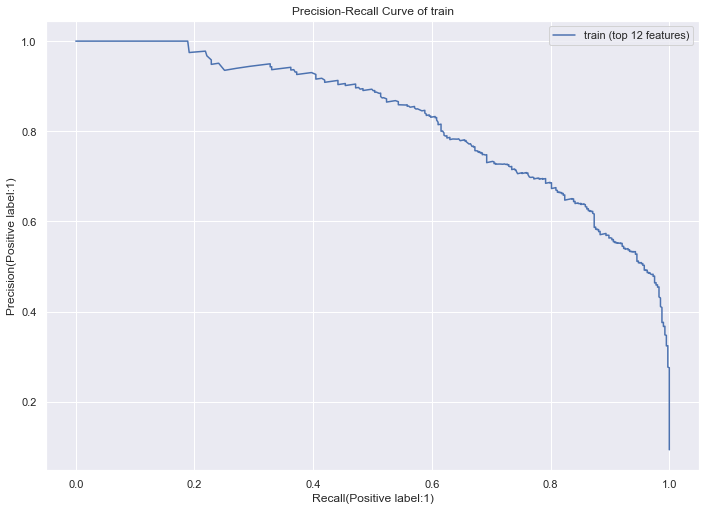

In [30]:
mp.plot_PR_train(12)

In [83]:
# PR AUC scores:
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc,plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
y_test_proba_reduct = model_reduct.predict_proba(X_test)
y_test_score_reduct= y_test_proba_reduct[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_score_reduct)
auc_precision_recall = auc(recall, precision)
print('test AUC: ',auc_precision_recall)
y_train_proba_reduct = model_reduct.predict_proba(X_train)
y_train_score_reduct= y_train_proba_reduct[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_train_score_reduct)
auc_precision_recall = auc(recall, precision)
print('train AUC: ',auc_precision_recall)


test AUC:  0.7220588216056325
train AUC:  0.826006517978531


# Hyperparameter Tuning

In [31]:
# TRy GridSearchCV to find the best hyperparameters

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
n_estimators = [5,10,15,20]
max_depth = [15, 25, 30]
min_samples_split = [50, 100, 150]
min_samples_leaf = [5,10,30,50,80] 
max_features=['auto', 'sqrt', 'log2']

hyperF = dict(rfc__n_estimators = n_estimators, 
              rfc__max_depth = max_depth,  
              rfc__min_samples_split = min_samples_split, 
              rfc__min_samples_leaf = min_samples_leaf,
              rfc__max_features=max_features)

gridF = GridSearchCV(model_reduct, hyperF, cv = 3, scoring='average_precision')
bestF = gridF.fit(X_train, y_train)

In [34]:
bestF.best_params_

{'rfc__max_depth': 15,
 'rfc__max_features': 'auto',
 'rfc__min_samples_leaf': 10,
 'rfc__min_samples_split': 50,
 'rfc__n_estimators': 20}

In [ ]:
rfc__n_estimators': 20,
 'rfc__min_samples_split': 50,
 'rfc__min_samples_leaf': 10,
 'rfc__max_features': 'log2',
 'rfc__max_depth': 30}

In [33]:
bestF

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Rescale', StandardScaler()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               max_depth=50,
                                                               min_samples_split=50,
                                                               n_estimators=5,
                                                               oob_score=True,
                                                               random_state=0))]),
             param_grid={'rfc__max_depth': [15, 25, 30],
                         'rfc__max_features': ['auto', 'sqrt', 'log2'],
                         'rfc__min_samples_leaf': [5, 10, 30, 50, 80],
                         'rfc__min_samples_split': [50, 100, 150],
                         'rfc__n_estimators': [5, 10, 15, 20]},
             scoring='average_precision')

In [36]:
# try RandomizedSearchCV to find the best hyperparameters

from sklearn.model_selection import RandomizedSearchCV #
from scipy.stats import uniform

distributions = dict(C=uniform(loc=0, scale=4),penalty=['l2', 'l1'])
clf = RandomizedSearchCV(model_reduct, param_distributions =hyperF  , random_state=0,scoring="average_precision")
search = clf.fit(X_train,y_train)
search.best_params_

{'rfc__n_estimators': 20,
 'rfc__min_samples_split': 50,
 'rfc__min_samples_leaf': 10,
 'rfc__max_features': 'log2',
 'rfc__max_depth': 30}

# Retrain the model

In [37]:
# train the model with the best hyperparameters

steps = [('Rescale', StandardScaler()),#use RandomizedSearchCV result
         ('rfc', RandomForestClassifier(n_estimators =20, criterion = 'entropy', 
                                     random_state = 0,class_weight='balanced',
                                     min_samples_split=50,oob_score=True,
                                     max_features='log2',max_depth=30,min_samples_leaf=10))]
model_ht = Pipeline(steps)
model_ht= model_ht.fit(X_train,y_train)
y_train_pred_ht = model_ht.predict(X_train)
y_test_pred_ht = model_ht.predict(X_test)


In [38]:
# Cross validation


from sklearn.model_selection import cross_val_score 
from sklearn.metrics import average_precision_score

y_train_proba_ht = model_ht.predict_proba(X_train)
y_train_score_ht= y_train_proba_ht[:, 1]
average_precision_score=average_precision_score(y_train,y_train_score_ht)


train_scores = cross_val_score(model_ht, X_train, y_train, scoring = 'average_precision', cv=5)
if train_scores.mean()<average_precision_score:
    print('overfitting')
else:
    print('not overfitting')
print('train_scores.mean',train_scores.mean())
print('average_precision_score',average_precision_score)
print('differencce',average_precision_score-train_scores.mean())


overfitting
train_scores.mean 0.7183750905671764
average_precision_score 0.8277701530669067
differencce 0.1093950624997303


In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
y_train_proba_ht = model_ht.predict_proba(X_train)
y_train_score_ht= y_train_proba_ht[:, 1]
precision, recall, thresholds = precision_recall_curve(y_train, y_train_score_ht)
auc_precision_recall = metrics.auc(recall, precision)
print('train AUC: ',auc_precision_recall)

y_test_proba_ht = model_ht.predict_proba(X_test)
y_test_score_ht= y_test_proba_ht[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_score_ht)
auc_precision_recall = metrics.auc(recall, precision)
print('test AUC: ',auc_precision_recall)

train AUC:  0.8275661006920181
test AUC:  0.7232435211018524


In [42]:
from MetricPipeline import Metric_pipeline    
mp=Metric_pipeline(X_train,y_train,X_test,y_test,model_ht)
mp.metrics()

,0,1
0,roc_auc_score(train),0.976
1,roc_auc_score(test),0.949
2,PR-AUC(train),0.828
3,PR-AUC(test),0.723
4,average_precision(train),0.828
5,average_precision(test),0.725
6,precision_score(train),0.949
7,precision_score(test),0.940


# Model Calibration

In [46]:
print('original test Fraud percentage: ',np.count_nonzero(y_test==1)/y_test.size)
print('predict test Fraud percentage:  ',np.count_nonzero(y_test_pred ==1)/y_test.size)

original test Fraud percentage:  0.09519408502772643
predict test Fraud percentage:   0.14695009242144177


In [47]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
rfc=CalibratedClassifierCV(model_ht, method='isotonic')#isotonic

rfc.fit(X_train,y_train)

y_test_proba_rfc = rfc.predict_proba(X_test)
y_test_proba_ht = model_ht.predict_proba(X_test)
fraction_of_positives,     mean_predicted_value         = calibration_curve(y_test, y_test_proba_ht[:,1], n_bins=10)
fraction_of_positives_rfc, mean_predicted_value_rfc     = calibration_curve(y_test, y_test_proba_rfc[:,1], n_bins=10)

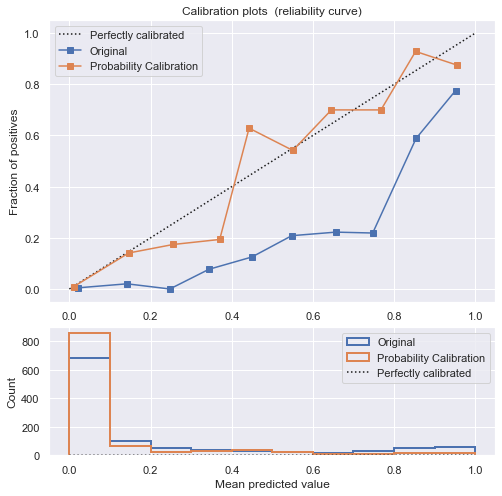

In [48]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",label="%s" % ('Original', ))
ax1.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-",label="%s" % ('Probability Calibration', ))
ax2.hist(y_test_proba_ht [:,1], range=(0, 1), bins=10, label='Original',
             histtype="step", lw=2)
ax2.hist(y_test_proba_rfc [:,1], range=(0, 1), bins=10, label='Probability Calibration',
             histtype="step", lw=2)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.set_ylabel("Fraction of positives")
ax1.set_title('Calibration plots  (reliability curve)')
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
# calibrated model shows better reliablity curve

In [49]:

from MetricPipeline import Metric_pipeline    
mp=Metric_pipeline(X_train,y_train,X_test,y_test,rfc)
mp.metrics()

,0,1
0,roc_auc_score(train),0.975
1,roc_auc_score(test),0.948
2,PR-AUC(train),0.816
3,PR-AUC(test),0.742
4,average_precision(train),0.815
5,average_precision(test),0.743
6,precision_score(train),0.948
7,precision_score(test),0.930


In [50]:
# calibration improved model probability estimation
from sklearn.metrics import brier_score_loss
brier_score_ht=brier_score_loss(y_test, y_test_proba_ht[:,1])
brier_score_rfc=brier_score_loss(y_test, y_test_proba_rfc[:,1])
print('original brier_score is : ', brier_score_ht)
print('Calibrated brier_score is : ',brier_score_rfc )

original brier_score is :  0.07163321822028085
Calibrated brier_score is :  0.042779105240155664


# Threshold

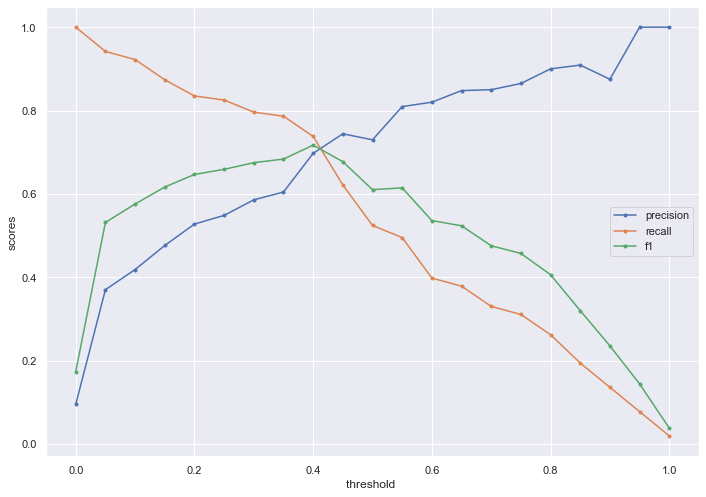

In [51]:
# use calibrated model result: rfc

from sklearn.metrics import f1_score,recall_score,precision_score # use calibrated model

p_score=[]
r_score=[]
f_score=[]
n=21
for i in np.linspace(0,1.0,n):
    y_test_pred_rfc =  ( y_test_proba_rfc [:, 1]>=i).astype(int)
    p=precision_score(y_test, y_test_pred_rfc)
    r=recall_score(y_test, y_test_pred_rfc)
    f=f1_score(y_test, y_test_pred_rfc)
    p_score.append(p)
    r_score.append(r)
    f_score.append(f)
    
        
    
plt.plot(np.linspace(0,1.0,n),p_score ,label='precision',marker='.')
plt.plot(np.linspace(0,1.0,n),r_score ,label='recall',marker='.')
plt.plot(np.linspace(0,1.0,n),f_score ,label='f1',marker='.')
ax = plt.gca()

plt.xlabel("threshold ")
plt.ylabel("scores")
plt.legend()


Test PR-AUC is 0.742


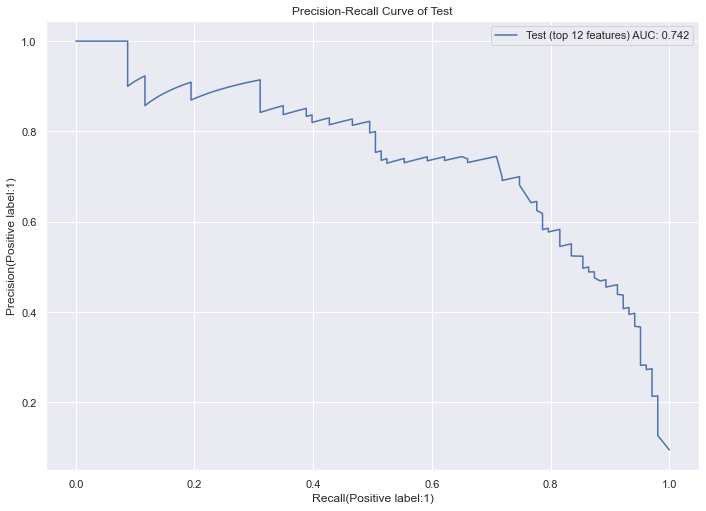

In [53]:
mp=multi_curves(X_train,y_train,X_test,y_test,rfc)
mp.plot_PR_test(12)

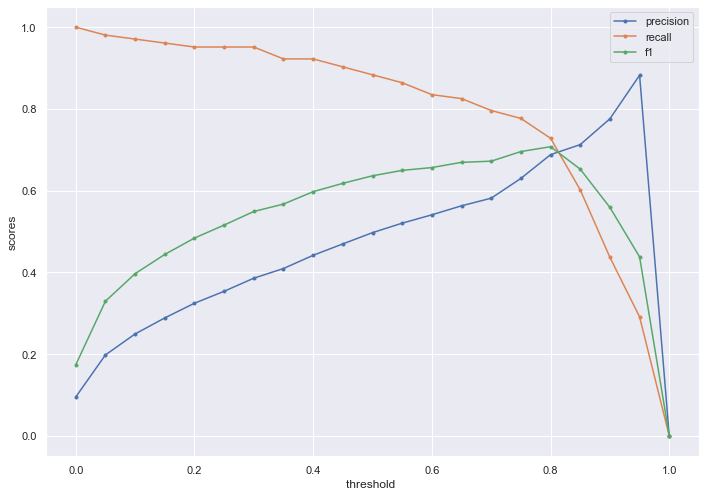

In [52]:
# use model result without calibration


from sklearn.metrics import f1_score,recall_score,precision_score 
p_score=[]
r_score=[]
f_score=[]
n=21
for i in np.linspace(0,1.0,n):
    y_test_pred_ht =  ( y_test_proba_ht [:, 1]>=i).astype(int)
    p=precision_score(y_test, y_test_pred_ht)
    r=recall_score(y_test, y_test_pred_ht)
    f=f1_score(y_test, y_test_pred_ht)
    p_score.append(p)
    r_score.append(r)
    f_score.append(f)
    
        
    
plt.plot(np.linspace(0,1.0,n),p_score ,label='precision',marker='.')
plt.plot(np.linspace(0,1.0,n),r_score ,label='recall',marker='.')
plt.plot(np.linspace(0,1.0,n),f_score ,label='f1',marker='.')
ax = plt.gca()

plt.xlabel("threshold ")
plt.ylabel("scores")
plt.legend()


Test PR-AUC is 0.723


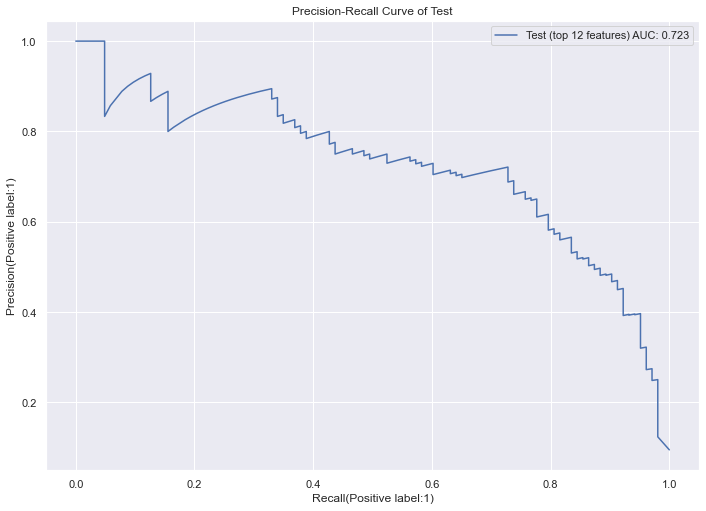

In [55]:
mp=multi_curves(X_train,y_train,X_test,y_test,model_ht)
mp.plot_PR_test(12)

# Conclusion

Original test PR_auc is 0.68 
Final test PR_auc is 0.742 
model improvment is 9.11%

# Save the models

In [56]:
import joblib
filename = 'model_final.sav'
joblib.dump(rfc, filename)

['model_final.sav']

In [57]:
rfc

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('Rescale',
                                                       StandardScaler()),
                                                      ('rfc',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              criterion='entropy',
                                                                              max_depth=30,
                                                                              max_features='log2',
                                                                              min_samples_leaf=10,
                                                                              min_samples_split=50,
                                                                              n_estimators=20,
                                                                              oob_score=True,
                                                                              random_state=0))]),
                       method='isotonic')